In [2]:
import sys
import os
sys.path.insert(2, '/global/project/projectdirs/lux/Tools/root_pdsf/root/lib')
from ROOT import TCanvas, TPad, TFile, TPaveText, TChain, TCut, TF1, TH2F
from ROOT import gBenchmark, gStyle, gROOT

In [3]:
import rootnotes_nersc
from rootnotes_nersc import rtshow, clearCanvas
from numpy import *
import scipy
import pylab
import matplotlib.pyplot as plt # plotting libraries from matlab
from scipy.stats import multivariate_normal

In [4]:
%pylab inline  
#always do this for plotting...  don't ask why
#now set the size of figures to display in window
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h1> load in Run03 WS data </h1>

In [5]:
chain = TChain('golden')
chain.Add('/project/projectdirs/lux/data/golden/Golden_Run03/Golden_150303_WS*.root')

9

<h1> Check for S1 stability in Run03 based on Kr peaks in the WS data </h1>

In [5]:
c3 = rootnotes_nersc.default_canvas(name='WS_S1')

In [6]:
fid_vol=TCut('drift>35 && drift<308 && correctedRadius<20')
area_cut=TCut('s2area_raw>150 && s1area>150 && s1area<350 && s2area<20000 && s2area>2000')
bad_area_cut=TCut('((goodArea<=630 && badArea < 80) || (goodArea>630 && badArea < 80+0.095*(goodArea-630)))')

In [7]:
#density_plt_hst=TH2F('S1_Kr_WS','S1_Kr_WS;luxstamp;S1_{c}',500,7250,8450,100,150,350)
#combined_cut=TCut(fid_vol.GetTitle() + '&&'+ area_cut.GetTitle() + '&&' + bad_area_cut.GetTitle())
#n=chain.Draw('s1area:(luxstamp/10**12)>>S1_Kr_WS',combined_cut,'colz')
n=chain.Draw('s1area:(luxstamp/10**12)',fid_vol+area_cut+bad_area_cut)

TStreamerInfo::BuildCheck:0: RuntimeWarning: 
   The StreamerInfo of class TAttMarker read from file /project/projectdirs/lux/users/acurrie/Run3_DP2.0/Golden_150220_WS1.root
   has the same version (=2) as the active class but a different checksum.
   You should update the version to ClassDef(TAttMarker,3).
   Do not try to write objects with the current class definition,
   the files will not be readable.

TStreamerInfo::CompareContent:0: RuntimeWarning: The following data member of
the on-file layout version 2 of class 'TAttMarker' differs from 
the in-memory layout version 2:
   short fMarkerColor; //
vs
   Color_t fMarkerColor; //
TStreamerInfo::CompareContent:0: RuntimeWarning: The following data member of
the on-file layout version 2 of class 'TAttMarker' differs from 
the in-memory layout version 2:
   short fMarkerStyle; //
vs
   Style_t fMarkerStyle; //
TStreamerInfo::CompareContent:0: RuntimeWarning: The following data member of
the on-file layout version 2 of class 'TAttMark

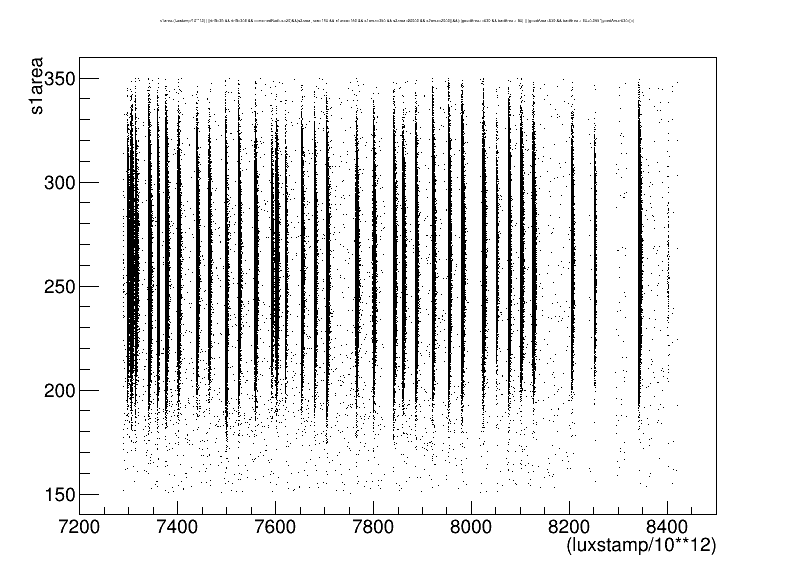

In [8]:
#c3.SetLogz(0)
#gStyle.SetOptStat(0)
#gStyle.SetPalette(55)
#gStyle.SetNumberContours(100)
rtshow(c3)
#c4.SaveAs('Run03_Golden_Doke/Golden.pdf')

In [9]:
s1c = ndarray( (n,),dtype= float64, buffer=(chain.GetV1()))
luxstamp = ndarray( (n,),dtype= float64, buffer=(chain.GetV2()))

In [10]:
cut=luxstamp > 1000;
s1c=s1c[cut]
luxstamp=luxstamp[cut]

In [11]:
H, xedges, yedges = histogram2d(luxstamp, s1c, bins=200, range=None, normed=False)
H=H.T
x_bin_center=(xedges[:-1]+xedges[1:])/2
y_bin_center=(yedges[:-1]+yedges[1:])/2

In [12]:
#HH, xedges = histogram(luxstamp, bins=200, range=None, normed=False)
#x_bin_center=(xedges[:-1]+xedges[1:])/2

left_edge=xedges[:-1]
right_edge=xedges[1:]

s1_means=zeros_like(x_bin_center)
s1_means_sig=zeros_like(x_bin_center)

for ii in range(0,x_bin_center.size):
    range_cut=(luxstamp>left_edge[ii]) & (luxstamp<right_edge[ii])
    s1_means[ii]=mean(s1c[range_cut])
    s1_means_sig[ii]= std(s1c[range_cut])/sqrt(s1c[range_cut].size)
    if s1c[range_cut].size <1000: # at least 1000 points for the fit
        s1_means[ii]=0


/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:95: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

In [13]:
# convert luxstamp to date_num
lux_epoch=datestr2num('Jan 1st 2011 at 00:00')

luxstamp2day=x_bin_center*10**4/3600/24
luxdatenum=luxstamp2day+lux_epoch

In [ ]:
sig_s1_mean=std(s1_means[s1_means>0]/mean(s1_means[s1_means>0]))

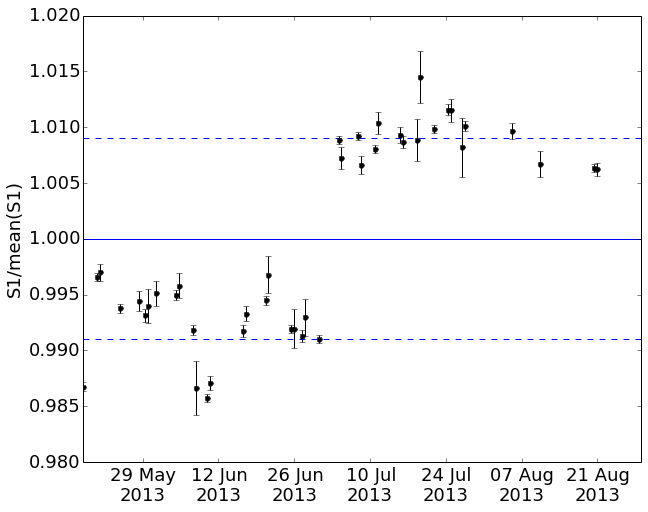

In [73]:
plt.plot_date(luxdatenum[s1_means>0],s1_means[s1_means>0]/mean(s1_means[s1_means>0]),'.k')
ax = gca()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %b\n%Y'))
plt.plot_date([luxdatenum.min(),luxdatenum.max()],[1,1],'-b')
plt.plot_date([luxdatenum.min(),luxdatenum.max()],[1.009,1.009],'--b')
plt.plot_date([luxdatenum.min(),luxdatenum.max()],[.991,.991],'--b')
plt.errorbar(luxdatenum[s1_means>0],s1_means[s1_means>0]/mean(s1_means[s1_means>0]),
             s1_means_sig[s1_means>0]/mean(s1_means[s1_means>0]),fmt=".k",markersize=10)
plt.rcParams.update({'font.size': 18}) #increase all fontsizes
#plt.xticks(fontsize=16)
plt.ylabel('S1/mean(S1)')
#plt.xlabel('Date')

<h1> Check for S2 stability in WS from Kr peaks </h1>

In [54]:
c4 = rootnotes_nersc.default_canvas(name='WS_S2')

In [55]:
fid_vol=TCut('drift>35 && drift<308 && correctedRadius<20')
area_cut=TCut('s2area_raw>150 && s1area>150 && s1area<350 && s2area<20000 && s2area>2000')
bad_area_cut=TCut('((goodArea<=630 && badArea < 80) || (goodArea>630 && badArea < 80+0.095*(goodArea-630)))')
n=chain.Draw('s2area/100:(luxstamp/10**12)',fid_vol+area_cut+bad_area_cut)

In [56]:
n

1474739L

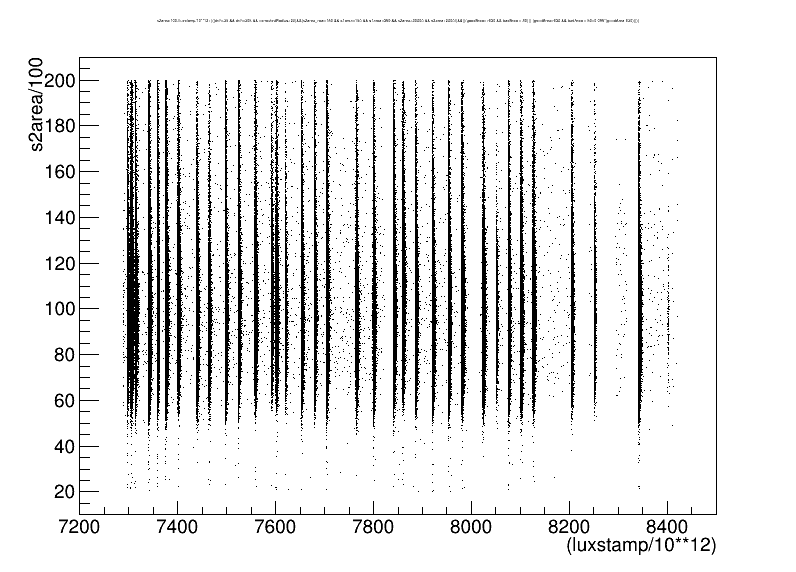

In [57]:
rtshow(c4)

In [58]:
s2c = ndarray( (n,),dtype= float64, buffer=(chain.GetV1()))
luxstamp = ndarray( (n,),dtype= float64, buffer=(chain.GetV2()))


In [59]:
cut=(luxstamp > 7200) & (luxstamp < 8400) ;
s2c=s2c[cut]
luxstamp=luxstamp[cut]

In [60]:
H, xedges, yedges = histogram2d(luxstamp, s2c, bins=200, range=None, normed=False)
H=H.T
x_bin_center=(xedges[:-1]+xedges[1:])/2
y_bin_center=(yedges[:-1]+yedges[1:])/2

left_edge=xedges[:-1]
right_edge=xedges[1:]

s2_means=zeros_like(x_bin_center)
s2_means_sig=zeros_like(x_bin_center)

for ii in range(0,x_bin_center.size):
    range_cut=(luxstamp>left_edge[ii]) & (luxstamp<right_edge[ii])
    s2_means[ii]=mean(s2c[range_cut])
    s2_means_sig[ii]= std(s2c[range_cut])/sqrt(s2c[range_cut].size)
    if s2c[range_cut].size <1000: # at least 1000 points for the fit
        s2_means[ii]=0



In [61]:
#plt.contourf(x_bin_center,y_bin_center,H,20)

In [62]:
# convert luxstamp to date_num
lux_epoch=datestr2num('Jan 1st 2011 at 00:00')

luxstamp2day=x_bin_center*10**4/3600/24
luxdatenum=luxstamp2day+lux_epoch

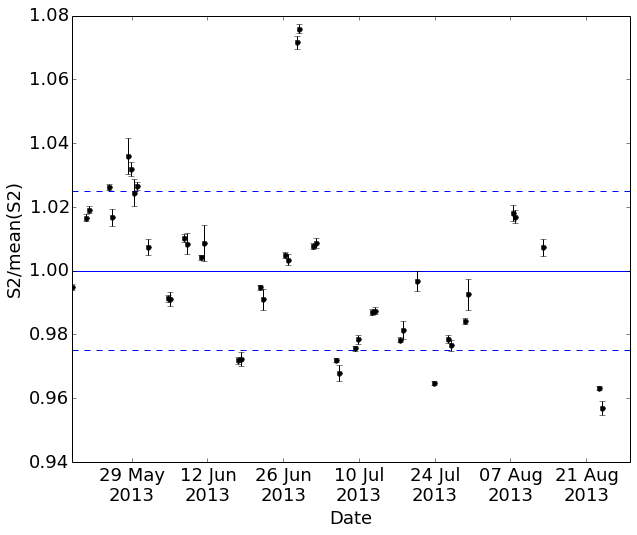

In [71]:
plt.plot_date(luxdatenum[s2_means>0],s2_means[s2_means>0]/mean(s2_means[s2_means>0]),'.k')
ax = gca()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %b\n%Y'))
plt.plot_date([luxdatenum.min(),luxdatenum.max()],[1,1],'-b')
plt.plot_date([luxdatenum.min(),luxdatenum.max()],[1.025,1.025],'--b')
plt.plot_date([luxdatenum.min(),luxdatenum.max()],[.975,.975],'--b')
plt.errorbar(luxdatenum[s2_means>0],s2_means[s2_means>0]/mean(s2_means[s2_means>0]),
             s2_means_sig[s2_means>0]/mean(s2_means[s2_means>0]),fmt=".k",markersize=10)
plt.rcParams.update({'font.size': 18}) #increase all fontsizes
plt.ylabel('S2/mean(S2)')
plt.xlabel('Date')

In [74]:
sig_s2_mean=std(s2_means[s2_means>0]/mean(s2_means[s2_means>0]))